[View in Colaboratory](https://colab.research.google.com/github/littlejiafan/colab/blob/master/DeepQforComputing&Caching.ipynb)

# Import Packages&Parameter Setting

In [1]:
# 显示进度的小工具
!pip install tqdm

In [0]:
import time
import sys

import numpy as np
import tensorflow as tf

import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
np.random.seed(1)
tf.set_random_seed(1)

In [3]:
#检测一下有没有GPU可以用

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# 因为参数太多了，很多参数直接在代码里直接用了

bs_number = 3  # number of base stations
user_number = 9  # number of users
channel_state = [[0.6,0.3,0.1],[0.3,0.1,0.6],[0.1,0.6,0.3]]  # Transition probability of computation capbility: Good, Medium, Bad
snr = [1, 3, 5]
bandwidth = 5 # MHz
cache_type = 3 

charge1 = 10
charge2 = 1
charge3 = 3
charge4 = 4
rho = 1
pay1 = 2
pay2 = 3
pay3 = 1
pay4 = 1  # 缓存状态更新代价
CPU_cycle = 100
content_size = 1
computation_capbility = 8
effect_factor = 0.9

# State&Action

In [0]:
# 由于缓存组合只有三种，分别用0, 1, 2表示缓存组合的类型，即0为支持type1和type2类型的缓存

# state格式:每个基站支持缓存的类型，用户的缓存状态，snr矩阵

state = np.array([0]*bs_number + [0]*user_number + [1]*user_number*bs_number)
n_features = bs_number + user_number + user_number*bs_number

# action格式:每个基站将要支持的缓存类型

action = np.array([0]*bs_number)  # 表明选择不缓存0类型
action_number = cache_type**bs_number

In [0]:
# 对state和action进行reset，这是完成一次训练后的重新开始

def reset(state, action):
    state = np.array([0]*bs_number + [0]*user_number + [1]*user_number*bs_number)
    action = np.array([0]*bs_number)

In [7]:
print(state)
print(action)

[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]
[0 0 0]


# State Transition&Reward

In [0]:
'''
本节和下节为仿真的重点。move是根据action对status进行修正，计算相应的reward并进行修正。
'''

def move(state, action):
    state_ = state.copy() # 记录当前状态
    
    bs_status = state[:bs_number]
    # print("bs:",bs_status)
    user_status = state[bs_number:bs_number + user_number]
    # print("user:",user_status)
    user_bs_snr = state[bs_number + user_number:]
    user_bs_snr = np.reshape(user_bs_snr, (user_number, bs_number))
    
    count = 0 # 统计缓存类型需要变更的基站数量
    
    # 根据action修改缓存类型
    
    for i in range(bs_number):
        if action[i] == 0:
            if bs_status[i] != 0:
                count += 1
                bs_status[i] = 0
        elif action[i] == 1:
            if bs_status[i] != 1:
                count += 1
                bs_status[i] = 1
        elif action[i] == 2:
            if bs_status[i] != 2:
                count += 1
                bs_status[i] = 2
    
    # 对每个基站连接的用户状态进行统计，每个用户连接snr最优的基站
    
    choice = []  # 记录每个用户这次所连接的基站序号
    for i in range(user_number):
        choice.append(np.argmax(user_bs_snr[i]))
        
    offloading_decision = []  # 记录offloading decision，对应文中的d
    for i in range(user_number):
        if bs_status[choice[i]] == user_status[i]:
            offloading_decision.append(0)
        else:
            offloading_decision.append(1)
    
    # 计算reward, we assume B_m equals., g_m equals. JUST TO SIMPLIFY.
    reward = (charge1 - pay1)*bandwidth*user_number - count*pay4
    # print(user_bs_snr)
    
    for i in range(user_number):
        reward += (charge2 - pay2)*offloading_decision[i]*user_bs_snr[i, choice[i]]*bandwidth\
        + (1 - offloading_decision[i])*(charge4*computation_capbility/rho - rho*pay3*(computation_capbility)**2)\
        + (1 - offloading_decision[i])*bandwidth*user_bs_snr[i, choice[i]]

    # 本文的状态转变主要是snr马尔科夫，其次是用户的需求分布
    
    for i in range(user_number):
        for j in range(bs_number):
            temp = np.random.uniform()
            if user_bs_snr[i, j] == 1:
                if temp < 0.1:
                    user_bs_snr[i, j] = 5
                elif temp<0.7:
                    user_bs_snr[i, j] = 3
            if user_bs_snr[i, j] == 3:
                if temp < 0.3:
                    user_bs_snr[i, j] = 5
                elif temp < 0.9:
                    user_bs_snr[i, j] = 1
            if user_bs_snr[i, j] == 5:
                if temp < 0.1:
                    user_bs_snr[i, j] = 1
                elif temp < 0.4:
                    user_bs_snr[i, j] = 3
                    
    for i in range(user_number):
        temp = np.random.uniform()
        if temp < 0.25:
            user_status[i] = 0
        elif temp < 0.5:
            user_status[i] = 1
        elif temp < 0.75:
            user_status[i] = 2
    
    # 将新的shape整合成原先的shape
    
    user_bs_snr = np.reshape(user_bs_snr, user_number*bs_number)
    # print()
    # print(type(bs_status))
    # print("bs_status:", bs_status)
    # print("user:", user_status)
    # print("snr:", user_bs_snr)
    state = np.concatenate((bs_status, user_status, user_bs_snr))
    
    return state_, reward

# DeepQNetwork Class

In [0]:
class DeepQNetwork:
    def __init__(
            self,
            n_actions,
            n_features,
            learning_rate=0.001,
            reward_decay=0.9,
            e_greedy=0.9,
            replace_target_iter=300,
            memory_size=2000,
            batch_size=100,
            e_greedy_increment=None,
            output_graph=False,
    ):
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon_max = e_greedy
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.epsilon_increment = e_greedy_increment
        self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max

        # total learning step
        self.learn_step_counter = 0

        # initialize zero memory [s, a, r, s_]
        self.memory = np.zeros((self.memory_size, n_features * 2 + 2))

        # consist of [target_net, evaluate_net]
        self._build_net()

        t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target_net')
        e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='eval_net')

        with tf.variable_scope('soft_replacement'):
            self.target_replace_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]

        self.sess = tf.Session()

        if output_graph:
            # $ tensorboard --logdir=logs
            tf.summary.FileWriter("logs/", self.sess.graph)

        self.sess.run(tf.global_variables_initializer())
        self.cost_his = [] #his means histroy

    def _build_net(self):
        # ------------------ all inputs ------------------------
        self.s = tf.placeholder(tf.float32, [None, self.n_features], name='s')  # input State
        self.s_ = tf.placeholder(tf.float32, [None, self.n_features], name='s_')  # input Next State
        self.r = tf.placeholder(tf.float32, [None, ], name='r')  # input Reward
        self.a = tf.placeholder(tf.int32, [None, ], name='a')  # input Action

        w_initializer, b_initializer = tf.random_normal_initializer(0., 0.3), tf.constant_initializer(0.1)

        # ------------------ build evaluate_net ------------------
        with tf.variable_scope('eval_net'):
            e1 = tf.layers.dense(self.s, 30, tf.nn.relu, kernel_initializer=w_initializer,
                                 bias_initializer=b_initializer, name='e1')
            e2 = tf.layers.dense(e1, 30, tf.nn.relu, kernel_initializer=w_initializer,
                                 bias_initializer=b_initializer, name='e2')
            self.q_eval = tf.layers.dense(e2, self.n_actions, kernel_initializer=w_initializer,
                                          bias_initializer=b_initializer, name='q')

        # ------------------ build target_net ------------------
        with tf.variable_scope('target_net'):
            t1 = tf.layers.dense(self.s, 30, tf.nn.relu, kernel_initializer=w_initializer,
                                 bias_initializer=b_initializer, name='t1')
            t2 = tf.layers.dense(t1, 30, tf.nn.relu, kernel_initializer=w_initializer,
                                 bias_initializer=b_initializer, name='t2')
            self.q_next = tf.layers.dense(t2, self.n_actions, kernel_initializer=w_initializer,
                                          bias_initializer=b_initializer, name='t3')

        # ------------------ bellman equation ------------------
        with tf.variable_scope('q_target'):
            q_target = self.r + self.gamma * tf.reduce_max(self.q_next, axis=1, name='Qmax_s_')    # shape=(None, )
            self.q_target = tf.stop_gradient(q_target)
            
        with tf.variable_scope('q_eval'):
            a_indices = tf.stack([tf.range(tf.shape(self.a)[0], dtype=tf.int32), self.a], axis=1)
            self.q_eval_wrt_a = tf.gather_nd(params=self.q_eval, indices=a_indices)    # shape=(None, )
            
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval_wrt_a, name='TD_error'))
            
        with tf.variable_scope('train'):
            self._train_op = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss)

    def store_transition(self, s, a, r, s_):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0
        transition = np.hstack((s, [a, r], s_))
        # replace the old memory with new memory
        index = self.memory_counter % self.memory_size
        self.memory[index, :] = transition
        self.memory_counter += 1

    def choose_action(self, observation):
        # to have batch dimension when feed into tf placeholder
        observation = observation[np.newaxis, :]

        if np.random.uniform() < self.epsilon:
            # forward feed the observation and get q value for every actions
            actions_value = self.sess.run(self.q_eval, feed_dict={self.s: observation})
            action_number = np.argmax(actions_value)
            reward_his.append(np.max(actions_value))
            if action_number < cache_type:
                k = 0
                m = 0
                c = action_number
            elif action_number < cache_type**2:
                k = 0
                m = int(action_number / cache_type)
                c = action_number % cache_type
            else:
                k = int(action_number / (cache_type**2))
                mc = action_number % (cache_type**2)
                m = int(mc / cache_type)
                c = mc % cache_type
            action = np.array([k, m, c])
        else:
            action = np.array([np.random.randint(0, cache_type), np.random.randint(0, cache_type), np.random.randint(0,cache_type)])
        return action

    def learn(self):
        # check to replace target parameters
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.sess.run(self.target_replace_op)
            # print('\ntarget_params_replaced\n')

        # sample batch memory from all memory
        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        batch_memory = self.memory[sample_index, :]

        _, cost = self.sess.run(
            [self._train_op, self.loss],
            feed_dict={
                self.s: batch_memory[:, :self.n_features],
                self.a: batch_memory[:, self.n_features],
                self.r: batch_memory[:, self.n_features + 1],
                self.s_: batch_memory[:, -self.n_features:],
            })

        self.cost_his.append(cost)

        # increasing epsilon
        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_step_counter += 1

    def plot_cost(self):
        plt.plot(np.arange(len(self.cost_his)), self.cost_his)
        plt.ylabel('Cost')
        plt.xlabel('training steps')
        plt.show()

# Run&Plot
pray for a good performance.

In [0]:
def plot_reward(reward_his):
    plt.plot(np.arange(len(reward_his[::1000])), reward_his[::1000])
    plt.ylabel('Utility')
    plt.xlabel('training steps')
    plt.show()

In [0]:
def run(RL, state, action, reward_his):
    for _ in tqdm(range(300)):
        reset(state,action)
        for step in range(4000):
            action = RL.choose_action(state)
            state_, reward = move(state, action)
            action_number = action[0] + action[1]*3 + action[2]*9
            RL.store_transition(state_, action_number, reward, state)
            if(step > 200) and (step % 5 == 0):
                RL.learn()    
    print('game over')

In [0]:
RL = DeepQNetwork(n_actions=action_number, n_features=n_features)

In [13]:
reward_his = []
run(RL, state, action, reward_his)

100%|██████████| 300/300 [31:57<00:00,  6.39s/it]

game over


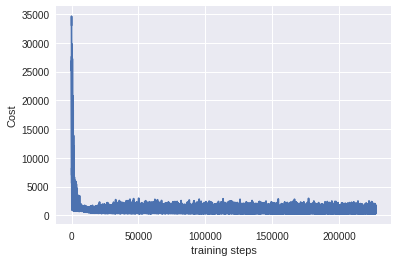

In [14]:
RL.plot_cost()

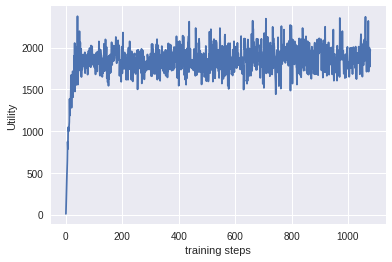

In [15]:
plot_reward(reward_his)

效果不好的原因：
1. reward选取问题
2. reward设计问题
2. 网络结构出现逻辑错误
3. 神经网络参数不当
4. dqn算法无法解决当前问题

由图一可以看出，我们可以在一定程度上学习到Q函数，因为loss逐渐变小嘛。但是reward却没上去，猜测方案一:因为它看得是长期收益而非当前收益，我们应当使用长期收益作为最后的价值。

改进方案：
1. 使用double dqn和dulex dqn
2. 调参
3. 使用更高级的神经网络和初始化方式：如更复杂的神经网络，使用ADAM
4. 弄清楚为什么会下降，我们明明处于一个稳定的系统了
            a. 系统并不知道已经达到最优，仍然继续学习，导致性能有所下降
5. 仿真参数特别是reward中的超参数